In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
path = '/Users/jeppegrejspetersen/Code/Final_project_AppML/era5'
input_files_msl = [f for f in os.listdir(path) if f.endswith('.nc') and 'mean_sea_level_pressure' in f]
input_files_msl

['era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc']

In [3]:
input_files_msl.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
input_files_msl

['era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc']

In [4]:
##merge the files from the list
file_paths_msl = [os.path.join(path, fname) for fname in input_files_msl]

# Then open all files with xarray
ds_msl = xr.open_mfdataset(file_paths_msl, combine='by_coords').sel(latitude=slice(70, 40), longitude=slice(-80, 22))

doy = ds_msl['valid_time'].dt.dayofyear
ds_msl = ds_msl.assign_coords(day_of_year=doy) ## 28 feb is 366. i have 2 of these in the 5 years.


def standard_scale_day(group, eps = 1e-6):
    mean_val = group.mean(dim='valid_time')
    std_val = group.std(dim='valid_time') + eps
    return (group - mean_val) / std_val

msl_stand = ds_msl['msl'].groupby('day_of_year').map(standard_scale_day)
ds_msl['msl_stand'] = msl_stand
ds_msl


<xarray.Dataset> Size: 723MB
Dimensions:      (valid_time: 1827, latitude: 121, longitude: 409)
Coordinates:
    number       int64 8B 0
  * latitude     (latitude) float64 968B 70.0 69.75 69.5 ... 40.5 40.25 40.0
  * longitude    (longitude) float64 3kB -80.0 -79.75 -79.5 ... 21.5 21.75 22.0
  * valid_time   (valid_time) datetime64[ns] 15kB 1940-01-01 ... 1944-12-31
    day_of_year  (valid_time) int64 15kB 1 2 3 4 5 6 ... 361 362 363 364 365 366
Data variables:
    msl          (valid_time, latitude, longitude) float32 362MB dask.array<chunksize=(92, 42, 320), meta=np.ndarray>
    msl_stand    (valid_time, latitude, longitude) float32 362MB dask.array<chunksize=(4, 42, 320), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-16T09:04 GRIB to CDM+CF via cfgrib-0.9.1...

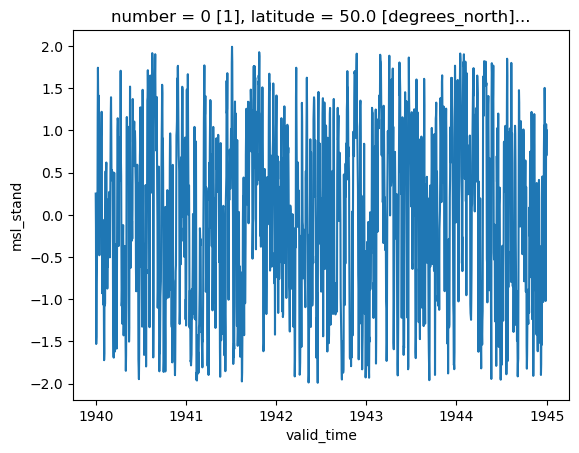

In [5]:
ds_msl.msl_stand.sel(longitude=0, latitude=50, method = 'nearest').plot()

In [6]:
msl_input = ds_msl.msl_stand.values

## cehck for nan
print(np.isnan(msl_input).any())

msl_input.shape

False


(1827, 121, 409)

['era5_1940_temperature_850hPa.nc', 'era5_1941_temperature_850hPa.nc', 'era5_1942_temperature_850hPa.nc', 'era5_1943_temperature_850hPa.nc', 'era5_1944_temperature_850hPa.nc']


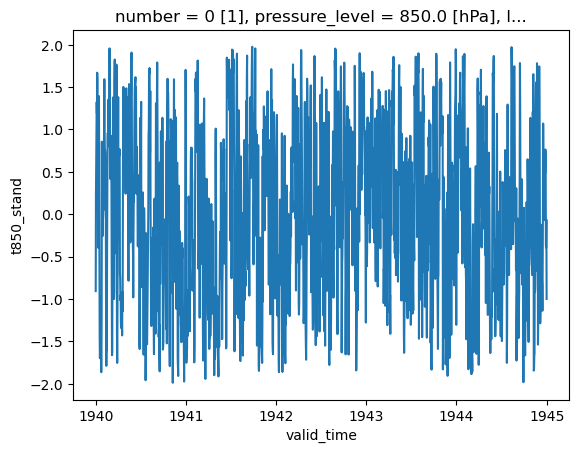

In [7]:
input_files_t850 = [f for f in os.listdir(path) if f.endswith('.nc') and '850' in f]
input_files_t850.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
print(input_files_t850)

file_paths_t850 = [os.path.join(path, fname) for fname in input_files_t850]
ds_t850 = xr.open_mfdataset(file_paths_t850, combine='by_coords').isel(pressure_level=0).sel(latitude=slice(70, 40), longitude=slice(-80, 22))

doy_t850 = ds_t850['valid_time'].dt.dayofyear
ds_t850 = ds_t850.assign_coords(day_of_year=doy_t850)
t850_stand = ds_t850['t'].groupby('day_of_year').map(standard_scale_day)
ds_t850['t850_stand'] = t850_stand
ds_t850.t850_stand.sel(longitude=0, latitude=50, method = 'nearest').plot()


In [8]:
t850_input = ds_t850.t850_stand.values

## check for nan in the data
print(np.isnan(t850_input).any())
t850_input.shape


False


(1827, 121, 409)

In [9]:
target_prec = [f for f in os.listdir(path) if f.endswith('.nc') and 'total' in f]
target_prec.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
target_prec



['era5_1940_total_precipitation.nc',
 'era5_1941_total_precipitation.nc',
 'era5_1942_total_precipitation.nc',
 'era5_1943_total_precipitation.nc',
 'era5_1944_total_precipitation.nc']

(1827,)

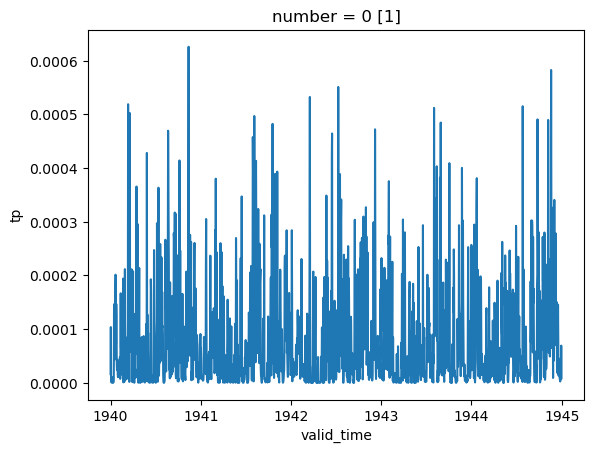

In [10]:
file_paths_prec = [os.path.join(path, fname) for fname in target_prec]
ds_prec = xr.open_mfdataset(file_paths_prec, combine='by_coords')
ds_prec = ds_prec.mean(dim= ['longitude', 'latitude'])
prec_target = ds_prec.tp.values
ds_prec.tp.plot()
prec_target.shape

In [11]:
import sys 

import torch
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary
from torcheval.metrics.functional import binary_f1_score
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# import preprocessing as prep
# import postprocessing as post
# import training as train
# import models as mod
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import pickle
from torch.utils.data import TensorDataset, DataLoader



In [12]:
X = np.stack([t850_input, msl_input], axis=1)
X.shape

(1827, 2, 121, 409)

In [13]:
##import standard scaler
from sklearn.preprocessing import MinMaxScaler

In [14]:
print(X.shape)
##take 250 random samples from X to test the model
random_indices = np.random.choice(X.shape[0], size=250, replace=False)
# Create a boolean mask for test data
mask = np.zeros(X.shape[0], dtype=bool)
mask[random_indices] = True

# Split the data using the mask
X_test = X[mask]
X_train = X[~mask]
scaler = MinMaxScaler()

y_test = scaler.fit_transform(prec_target[mask].reshape(-1, 1))
y_train =scaler.transform(prec_target[~mask].reshape(-1, 1))

# Check the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)




(1827, 2, 121, 409)
(1577, 2, 121, 409)
(1577, 1)
(250, 2, 121, 409)
(250, 1)


In [15]:
X_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)
print(X_tensor.shape)
print(y_tensor.shape)
X = X_tensor.view(1827-250, -1)
y = y_tensor.view(1827-250, 1)

# Create dataset
dataset = TensorDataset(X, y)


torch.Size([1577, 2, 121, 409])
torch.Size([1577, 1])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super().__init__()

        #hidden_dims = [4096, 2048, 2048, 2048, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 256]
        #hidden_dims = [2048, 2048,1024, 1024,1024, 1024, 256]
        hidden_dims = [2048, 1024, 512, 256]
        #hidden_dims = [512, 512, 256, 256]


        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim)) 
            layers.append(nn.ELU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        # Final output layer
        layers.append(nn.Linear(prev_dim, 1))

        # Use Sequential for compactness
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Model setup
input_dim = 2 * 121 * 409

model = FFNN(input_dim)

In [17]:
# Print model summary
summary(model, input_size=(1, input_dim), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
FFNN                                     [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 2048]                 202,708,992
│    └─BatchNorm1d: 2-2                  [1, 2048]                 4,096
│    └─ELU: 2-3                          [1, 2048]                 --
│    └─Dropout: 2-4                      [1, 2048]                 --
│    └─Linear: 2-5                       [1, 1024]                 2,098,176
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─ELU: 2-7                          [1, 1024]                 --
│    └─Dropout: 2-8                      [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─ELU: 2-11                         [1, 512]      

Epoch 1/100 — Train Loss: 0.0952 — Val Loss: 0.0258
Epoch 2/100 — Train Loss: 0.0948 — Val Loss: 0.0251
Epoch 3/100 — Train Loss: 0.0890 — Val Loss: 0.0246
Epoch 4/100 — Train Loss: 0.0841 — Val Loss: 0.0255
Epoch 5/100 — Train Loss: 0.0818 — Val Loss: 0.0246
Epoch 6/100 — Train Loss: 0.0817 — Val Loss: 0.0255
Epoch 7/100 — Train Loss: 0.0830 — Val Loss: 0.0263
Epoch 8/100 — Train Loss: 0.0793 — Val Loss: 0.0259
Early stopping triggered.


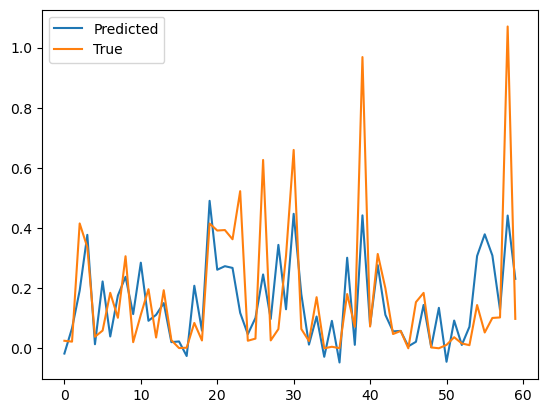

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split


# Data split (already good)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Loss, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:            
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:  # small threshold for improvement
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # optional: save best model

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            plt.plot(pred.detach().numpy(), label='Predicted')
            plt.plot(y_batch.detach().numpy(), label='True')
            plt.legend()
            break


mse 0.018625462


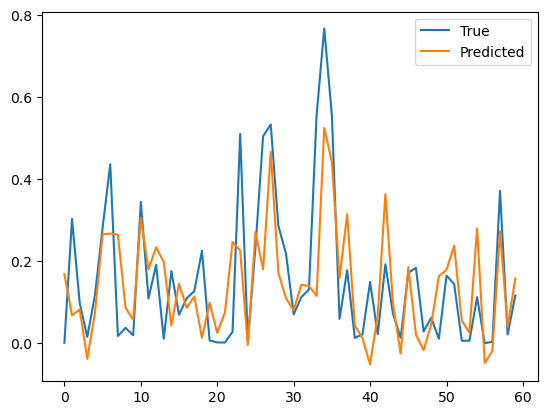

In [27]:
plt.plot(y_test[:60], label='True')# Reshape to (batch_size, channels=2, height=121, width=409)

y_pred = model(torch.from_numpy(X_test).view(250, -1)).detach().numpy()
plt.plot(y_pred[:60], label='Predicted')

print(f"mse", np.mean((y_test - y_pred) ** 2))
plt.legend()